# The Variational Quantum Linear Solver

#### Editor's note:

Consulted Pennylane tutorial on VQLS, found [here](https://pennylane.ai/qml/demos/tutorial_vqls).

Qiskit version: `1.4.2`

## 1. Introduction

The Variational Quantum Linear Solver (VQLS) is a kind of variational quantum algorithm (VQA) that solves systems of linear equations. 

Given a matrix $A$, such that $A |x\rangle \ = \ |b\rangle$, where $|b\rangle$ is some known vector, the VQLS algorithm finds a normalized $|x\rangle$ that is proportional to $|x\rangle$, which makes the above equation true.



## 2. The Algorithm

We start off with a qubit register, with each qubit initialized to $|0\rangle$. 

First, we prepare a candidate solution, $|x(\alpha)\rangle$ conditioned on a set of parameters $\alpha$. This is done using an ansatz $V(\alpha)$, where $|x(\alpha)\rangle = V(\alpha) |0\rangle$. Next, prepare $|b\rangle = U|0\rangle$ for some unitary $U$.

Second, we design a quantum circuit to compute a cost, $C(\alpha)$, that captures the idea of the difference between $| x(\alpha) \rangle$ and the real solution, $|x_0\rangle$, to $A {|x\rangle} = {|b\rangle}$.

If the cost is greater than some parameter $\gamma$, the algorithm is run again with updated parameters, and if not, the algorithm terminates.

Next, using classical methods, we find a new parameter, $\alpha$, that reduces $C(\alpha)$.

We repeat this process until $C(\alpha)$ falls within a reasonable limit, at which point we settle with $|x(\alpha)\rangle$ as the final solution.

![alt text](images/bro.png)

### Cost Function

Several cost functions are proposed:

1. $C_G$

$$C_G = 1 - | \langle b| \frac{|\psi\rangle}{\|\psi\|} \rangle |^2$$

We project $|\psi\rangle = A |x(\alpha)\rangle$ onto the subspace orthogonal to $|b\rangle$.
$C_G(\alpha)$ equals the norm squared of the projection.

Note that $|\psi\rangle$ is not normalized, so we need to normalize it before computing the projection.

As the number of qubits increases, the gradient of $C_G$ vanishes so we introduce the local cost function.

<br>

2. $C_L$, a local version of $C_G$.

First, let us define

$$P_1 = \left( \mathbb{1} - \frac{1}{n} \sum_{j=1}^{n} |0_j \rangle \langle 0_{j} | \otimes \mathbb{1}_{\bar{j}} \right)$$

where $\mathbb{1}_{\bar{j}}$ is the identity on all qubits except the j-th qubit.

Also,

$$P_0 = \frac{1}{2} + \frac{1}{2n} \sum_{j=1}^{n} Z_j
$$
where $Z_j$ is the Pauli-Z operator on the j-th qubit and identity on every other qubit.

When multipled by a standard-basis vector, $P_0$ counts the number of 0's in the vector, and $P_1$ counts the number of 1's. For example, if $|a \rangle$ has $m$ 1's and $n$ qubits, then $P_1 |a\rangle = \frac{m}{n} |a\rangle$, and $P_0 |a\rangle = \frac{n-m}{n} |a\rangle$.

Notice that

$$P_1 = \mathbb{1} - P_0 $$

Therefore,

$$C_L = \frac{\hat{C}_L} {\| \psi\|^2} = \frac{\langle x | H_L | x \rangle} {\| \psi\|^2}$$

$$ = \frac{\langle x | A^\dagger U P_1 U^\dagger A | x \rangle} {\langle x | A^\dagger A | x \rangle}$$

$$ = \frac{\langle x | A^\dagger U P_1 U^\dagger A | x \rangle} {\langle x | A^\dagger U \mathbb{1} U^\dagger A | x \rangle}$$

$$ = \frac{\langle x | A^\dagger U \mathbb{1} U^\dagger A | x \rangle - \langle x | A^\dagger U P_0 U^\dagger A | x \rangle} {\langle x | A^\dagger U \mathbb{1} U^\dagger A | x \rangle}$$

$$ = 1 - \frac{\langle x | A^\dagger U P_0 U^\dagger A | x \rangle} {\langle x | A^\dagger A | x \rangle}$$

$$ = \frac{1}{2} - \frac{1}{2n} \frac{\sum_{j=1}^{n}\langle x | A^\dagger U Z_j U^\dagger A | x \rangle} {\langle x | A^\dagger A | x \rangle}$$

$$ = \frac{1}{2} - \frac{1}{2n} \frac{\sum_{j=1}^{n}\langle 0|V^\dagger A^\dagger U Z_j U^\dagger A V|0 \rangle} {\langle 0|V^\dagger A^\dagger A  V|0 \rangle}$$


Since controlled-Z gate is native to IBM Heron processor, we can directly implement Controlled-$Z_j$ gates to improve efficiency of the algorithm for IBM Heron processors.

Since

$$A = \sum_{l=1}^{L} c_lA_l$$
where $c_l \in \mathbb{C}$, we can expand $A$ to obtain

$$ C_L = \frac{1}{2} - \frac{1}{2n} \frac{\sum_{j=1}^{n} \sum_{l=1}^{L} \sum_{l'=1}^{L} c_lc_{l'}^*\langle 0|V^\dagger A_{l'}^\dagger U Z_j U^\dagger A_l V|0 \rangle} {\sum_{l=1}^{L} \sum_{l'=1}^{L} c_lc_{l'}^* \langle 0|V^\dagger A_{l'}^\dagger A_l  V|0 \rangle}$$


## 3. Building Quantum Circuit with Qiskit



### Importing libraries

In [2]:
%pip install --upgrade -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
from IPython.display import display

import qiskit as qk
from qiskit import transpile
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile, assemble
from qiskit.circuit.library import UGate
from qiskit.exceptions import QiskitError
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, EstimatorOptions
from qiskit.quantum_info import Statevector, Operator, PauliList, Operator, SparsePauliOp, Pauli
from qiskit.transpiler.passes import RemoveBarriers
from qiskit.visualization import array_to_latex, plot_histogram

import math
import random
import numpy as np
from numpy import pi
from numpy import array, sqrt
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# For high-performance simulation
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as AerEstimatorV2

print(f"Qiskit version: {qk.__version__}")

Qiskit version: 1.4.2


### Consider an Example

Let us construct a 4x4 tridiagonal matrix, $A$. We generate a random vector $|x_0\rangle$ and obtain $|b\rangle$ from the equation $A |x_0\rangle =|b\rangle$. 

We apply VQLS, using $A$ and $|b\rangle$ as inputs, to solve for $|x\rangle$ in $A |x\rangle =|b\rangle$. We then compare our solution with the real solution $|x_0\rangle$.

In [4]:
A = np.array([[2,-1,0,0],
            [-1,2,-1,0],
            [0,-1,2,-1],
            [0,0,-1,2]])

print("Define the matrix, A, to be the following:")
display(array_to_latex(A))

Define the matrix, A, to be the following:


<IPython.core.display.Latex object>

### Decomposing A into LCU

We decompose $A$ into a Linear Combination of Pauli Strings (LCU). This is done by writing $A$ as a sum of Pauli operators, each multiplied by a coefficient.

In [5]:
# Apply SparsePauliOp()
LCU = SparsePauliOp.from_operator(A)
print(LCU, end="\n\n")

print("The Pauli strings are:")
print(LCU.paulis, end="\n\n")

print("The coefficients are:")
print(LCU.coeffs)

print(f"\nThe number of qubits is {LCU.num_qubits}.")

SparsePauliOp(['II', 'IX', 'XX', 'YY'],
              coeffs=[ 2. +0.j, -1. +0.j, -0.5+0.j, -0.5+0.j])

The Pauli strings are:
['II', 'IX', 'XX', 'YY']

The coefficients are:
[ 2. +0.j -1. +0.j -0.5+0.j -0.5+0.j]

The number of qubits is 2.


Hence, we have

$$
A = 2II - 1IX - 0.5XX - 0.5YY
$$

where $I$, $X$, $Y$ are Pauli matrices. 

### Defining Controlled-A Circuits
For the Hadamard Test, let us define the function `CA()` that creates controlled circuits for each Pauli string in the LCU. 

IX


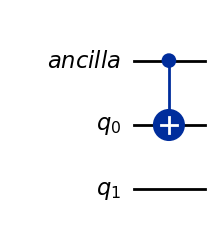

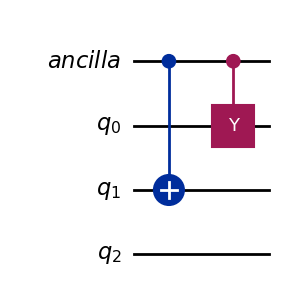

In [6]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Pauli, PauliList
from qiskit.exceptions import QiskitError

def CA(pauli_input, l=None):
    """
    Creates a controlled-Pauli circuit using an ancilla qubit as the control.
    
    Parameters:
        pauli_input (str, Pauli, PauliList or SparsePauliOp): 
            - A Pauli string (e.g., "IXY").
            - A Qiskit Pauli object (e.g., from SparsePauliOp.paulis[0]).
            - A Qiskit PauliList object, where the l-th Pauli will be used.
            - A Qiskit SparsePauliOp object, where the l-th Pauli will be used.
    
    The circuit uses two registers:
        - An ancilla register of size 1 named "ancilla" (the control qubit).
        - A data register of size nqubits named "q" (the target qubits).
    
    For each position in the Pauli operator:
        - 'I': Do nothing.
        - 'X': Apply a controlled-X (CX) gate.
        - 'Z': Apply a controlled-Z (CZ) gate.
        - 'Y': Apply a controlled-Y (CY) gate.
    
    Returns:
        QuantumCircuit: The constructed controlled-Pauli circuit.
    """
    
    # Convert input to a Pauli object if it is a string
    if isinstance(pauli_input, str):
        try:
            pauli = Pauli(pauli_input)  # Convert string to Pauli object
        except QiskitError:
            raise ValueError(f"Invalid Pauli string '{pauli_input}'. Allowed characters: I, X, Y, Z.")
    
    # If input is already a Pauli object, use it directly
    elif isinstance(pauli_input, Pauli):
        pauli = pauli_input
    
    # If input is PauliList or SparsePauliOp, extract the l-th pauli string
    elif isinstance(pauli_input, PauliList):
        try:
            pauli = pauli_input[l]  # Extract l-th pauli string
        except QiskitError:
            raise ValueError("The index, l, must be supplied if pauli_input contains more than one pauli string.")
        except IndexError:
            raise ValueError("The index, l, is out of bounds for the given PauliList.")
    
    elif isinstance(pauli_input, SparsePauliOp):
        try:
            pauli = pauli_input.paulis[l]  # Extract l-th pauli string
        except QiskitError:
            raise ValueError("The index, l, must be supplied if pauli_input contains more than one pauli string.")
        except IndexError:
            raise ValueError("The index, l, is out of bounds for the given PauliList.")
    
    # Reject invalid types
    else:
        raise TypeError(f"Expected input type str, Pauli, PauliList, or SparsePauliOp, but received {type(pauli_input)}.")
    
    # Determine the number of qubits
    nqubits = pauli.num_qubits
    
    # Create registers
    ancilla = QuantumRegister(1, name="ancilla")
    data = QuantumRegister(nqubits, name="q")
    
    # Create circuit
    circ = QuantumCircuit(ancilla, data, name="CA")
    
    # Loop over each Pauli term directly from the Pauli object
    for i, p in enumerate(pauli.to_label()):  # Ensure compatibility with string indexing. 
        # pauli.to_lable() converts Pauli Object to a string, e.g. "IXY"
        
        # Qiskit follows little Endian convention for qubit ordering. 
        # The most signifcant qubit is the one on the left in hand-written form. 
        # Hence, we need to reverse the index to match qubit numbering.
        i = nqubits - i - 1
        # E.g. nqubits =3, [0,1,2] becomes [2,1,0]
        
        if p == "I":
            continue
        elif p == "X":
            circ.cx(ancilla[0], data[i])
        elif p == "Z":
            circ.cz(ancilla[0], data[i])
        elif p == "Y":
            circ.cy(ancilla[0], data[i])
        else:
            raise ValueError(f"Unsupported Pauli operator: {p}")
    
    return circ
print(LCU.paulis[1])
display(CA(LCU.paulis[1]).draw("mpl"))
display(CA("IXY").draw("mpl"))

### Implement $|b\rangle$ with $U |0\rangle$

For simplicity, let use a $|b\rangle$ that is easy to implement. Let
$$|b\rangle = \frac{1}{2} \begin{pmatrix} 1 \\ 1 \\ 1 \\ 1 \end{pmatrix}$$

$|b\rangle$ can be prepared by applying a Hadamard gate to each qubit.

Given $A$ and $b$, we can easily obtain the solution x for validating the result.

$$|x\rangle = \begin{pmatrix} 1 \\ 1.5 \\ 1.5 \\ 1 \end{pmatrix}$$

In [ ]:
# Solution to Ax = b
x = np.array([1,1.5,1.5,1])
np.matmul(A,x)

# The normalized solution x_0
x_0 = x/np.linalg.norm(x)
print("Normalized x: ", x_0)
display(array_to_latex(x_0))

Normalized x:  [0.39223227 0.58834841 0.58834841 0.39223227]


<IPython.core.display.Latex object>

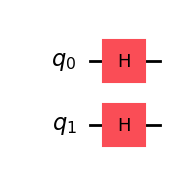

In [ ]:
def U_hadamard(nqubits):
    """
    Creates a circuit of size 'nqubits' that represents U_hadamard.
    For our problem, we only need to apply Hadamard on each qubit to prepare |b>.
    
    In general, U_b would be a unitary that maps |0> to |b> (or vice versa).
    
    Returns:
        circuit (QuantumCircuit): A quantum circuit of size 'nqubits'.
    """
    circ = QuantumCircuit(nqubits, name="U_hadamard")
    # Example placeholder: apply H on each qubit
    for i in range(nqubits):
        circ.h(i)
    return circ

# |b> with two qubits:
display(U_hadamard(2).draw("mpl"))

### Fixed Structure Ansatz for $|x(\alpha)\rangle$
Consider the ansatz $V(\alpha)$, quantum a circuit that prepares a state $|x(\alpha)\rangle$ given a set of parameters, $\alpha$. 

There different techniques for preparing the ansatz, including fixed ansatz, variable ansatz and Quantum Alternating Operator Ansatz (QAOA). 

Here, we use a very basic fixed ansatz.

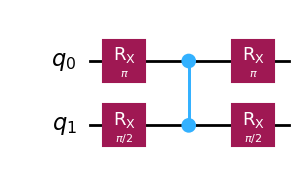

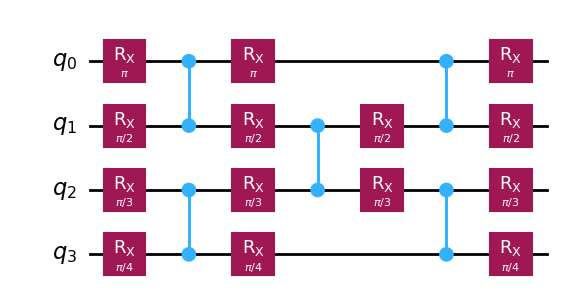

In [8]:

def apply_single_qubit_rotation(circuit, gate_type, angle, qubit_idx):
    gate_type = gate_type.strip().lower()
    if gate_type == "rx":
        circuit.rx(angle, qubit_idx)
    elif gate_type == "ry":
        circuit.ry(angle, qubit_idx)
    elif gate_type == "rz":
        circuit.rz(angle, qubit_idx)
    else:
        raise ValueError(f"Unsupported rotational gate: {gate_type}. Available gates are 'rx', 'ry', 'rz'.")

# Helper to apply two-qubit entangling gates
def apply_two_qubit_entangling(circuit, gate_type, ctrl, tgt):
    gate_type = gate_type.strip().lower()
    if gate_type == "cz":
        circuit.cz(ctrl, tgt)
    elif gate_type == "cx":
        circuit.cx(ctrl, tgt)
    elif gate_type == "cy":
        circuit.cy(ctrl, tgt)
    else:
        raise ValueError(f"Unsupported entangling gate: {gate_type}. Available gates are 'cz', 'cx', 'cy'.")


def fixed_ansatz(parameters, nqubits=None, rotational_gates = "Rx", entangling_gates = "CZ"):
    """
    Creates a parameterized "ansatz circuit" on 'nqubits' data qubits.
    
    Input:
    parameters (list of list): A list of layers of rotational gates, for example [[θ₀, θ₁, ...], [θ₂, θ₃, ...], ...].
        Each inner-list must have length equal to nqubits.
    nqubits (int): The number of data qubits in the circuit. If not specified, it will be determined from the parameters.
    rotational_gates (str): The type of rotational gate to use. Default is "Rx".
    entangling_gates (str): The type of entangling gate to use. Default is "CZ".
    
    Between each layer (except the last), an entangling layer is inserted.
    The entangling pattern alternates:
    - For even layers (0, 2, ...): apply entangling gates on pairs (0,1), (2,3), ...
    - For odd layers (1, 3, ...): apply entangling gates on pairs (1,2), (3,4), ...
    
    In a non-final layer, rotational gates are only applied to qubits that will be entangled in the next layer.
    
    Output:
    QuantumCircuit: The constructed ansatz circuit.
    """
    num_layers = len(parameters)
    
    # If nqubits is not specified, determine it from the parameters.
    if nqubits is None:
        nqubits = max(len(parameters[i]) for i in range(num_layers))
    
    # Initialize the ansatz circuit.
    ansatz = QuantumCircuit(nqubits, name="ansatz")
    
    for layer_idx, layer in enumerate(parameters):
        # For non-final layers, determine qubits that will be entangled in the next layer.
        if layer_idx < num_layers - 1:
            if layer_idx % 2 == 0:
                # Even layer: entangle pairs (0,1), (2,3), ...
                entangled = {i for pair in range(0, nqubits - 1, 2) for i in (pair, pair + 1)}        
            else:
                # Odd layer: entangle pairs (1,2), (3,4), ...
                entangled = {i for pair in range(1, nqubits - 1, 2) for i in (pair, pair + 1)}
            # Apply Ry only on qubits that will be involved in the next CZ layer.
            for i, theta in enumerate(layer[:nqubits]):
                if i in entangled:
                    apply_single_qubit_rotation(ansatz, rotational_gates, theta, i)
                    # ansatz.rx(theta, i)
        else:
            # For the final layer, apply Ry to all qubits.
            for i, theta in enumerate(layer[:nqubits]):
                apply_single_qubit_rotation(ansatz, rotational_gates, theta, i)
                # ansatz.rx(theta, i)
                
        # After each layer (except the final one) insert the alternating CZ entangling layer.
        if layer_idx < num_layers - 1:
            if layer_idx % 2 == 0:
                for i in range(0, nqubits - 1, 2):
                    apply_two_qubit_entangling(ansatz, entangling_gates, i, i + 1)
                    # ansatz.cz(i, i + 1)
            else:
                for i in range(1, nqubits - 1, 2):
                    apply_two_qubit_entangling(ansatz, entangling_gates, i, i + 1)
                    # ansatz.cz(i, i + 1)
                    
    return ansatz

params1 = [[pi/1, pi/2], [pi/1, pi/2]]

params2 = [[pi/1, pi/2, pi/3, pi/4], 
            [pi/1, pi/2, pi/3, pi/4], 
            [pi/1, pi/2, pi/3, pi/4], 
            [pi/1, pi/2, pi/3, pi/4]]

# Display the circuits with modified parameters
display(fixed_ansatz(parameters=params1, nqubits=2).draw("mpl"))
display(fixed_ansatz(params2).draw("mpl"))

Only the parameters change for each run of the circuit. The $Rx$ gates search the state space, while the $CZ$ gates create "interference" between qubits. 


> Correction: Rz and CZ gates are native to IBM Heron processors. Rx is not. 

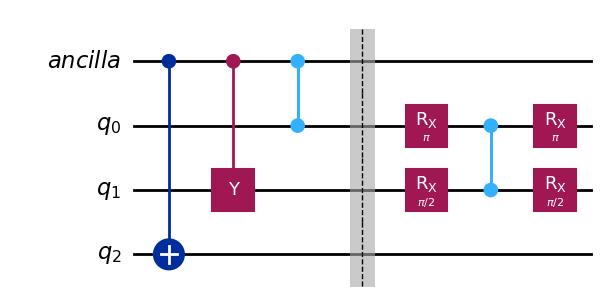

In [9]:
# Testing circuit composition

ancilla = QuantumRegister(1, name="ancilla")
data = QuantumRegister(3, name="q")
test_circ = QuantumCircuit(ancilla, data)

test_circ.compose(CA("XYZ"), inplace=True)
test_circ.barrier()
test_circ.compose(fixed_ansatz(parameters=params1, nqubits=2), qubits=data[0:2], inplace=True)

display(test_circ.draw("mpl"))

### Hadamard Test for $C_L$

To calculate the local cost, we can use `Hadamard Test` circuit. The paper [5] introduces a new circuit, `Hadamard-Overlap Test`, to compute $C_L$. 

Recall the local cost, $C_L$:

$$ C_L = \frac{1}{2} - \frac{1}{2n} \frac{\sum_{j=1}^{n} \sum_{l=1}^{L} \sum_{l'=1}^{L} c_lc_{l'}^*\langle 0|V^\dagger A_{l'}^\dagger U Z_j U^\dagger A_l V|0 \rangle} {\sum_{l=1}^{L} \sum_{l'=1}^{L} c_lc_{l'}^* \langle 0|V^\dagger A_{l'}^\dagger A_l  V|0 \rangle}$$

A basic `Hadamard Test` looks like this, where $|\psi \rangle$ is the state of the data qubits and $|0\rangle$ is the ancilla qubit. 

This Hadamard test is designed to calculate $\langle \psi|U|\psi \rangle$. Let the probability of measuring $|0\rangle$ be $p_0$ and the probability of measuring $|1\rangle$ be $p_1$. According the theory on the Hadamard Test, the real part would be $Re = p_0 - p_1$. The imaginary part can also be calculated using a slight different circuit. 

To get the real (and imaginary) part, measuring the ancilla qubit is not the most efficient method. 

A more efficient method is to use one of the qiskit primitives, `Estimator` or `EstimatorV2` (the other one is `Sampler`). 

Suppose the ancilla qubit is $|\psi\rangle$, then the expectation value is $\langle \psi | Z | \psi \rangle = p_0 - p_1 = Re$

Hence, in our case, we want to measure the expectation value of Pauli-Z on the ancilla qubit. 

![Hadamard test](images\Hadamard_test.webp)

Below is the circuit we want to build using Hadamard Test: 

Notice that for Pauli matrices, $A_l = A_{l}^\dagger$.

![Image from Pennylane](images\vqls_hadamard_test_circuit.png)

#### Constructing the Hadamard Test circuit

A_l is: IX
A_l' is: XX
j = 0

For the real part:


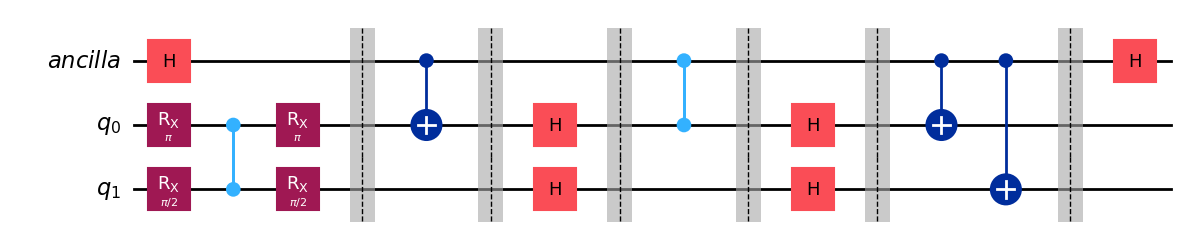

For the imaginary part:


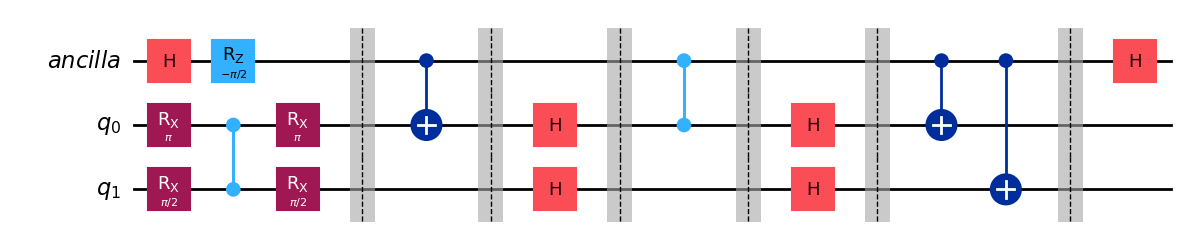

In [10]:

def local_hadamard_test(parameters, l, j, lp, part="Re", nqubits=None, lcu = None):
    """
    Builds the main circuit for the local Hadamard test as in your diagram.

    Args:
        parameters (list): Parameters for fixed_ansatz, e.g. [[1,1],[1,1]].
        nqubits (int): Number of data qubits (not counting the ancilla).
        l (str): Pauli string for A_l (e.g. "IX").
        j (int): Index of the data qubit for the controlled-Z. If j = -1, skip the CZ.
        lp (str): Pauli string for A_{l'}.
        part (str): "Re" or "Im". If "Im", apply a phase shift Rz(-pi/2) on the ancilla
                    to measure the imaginary part.

    Returns:
        QuantumCircuit: The complete Hadamard test circuit with measurement on the ancilla.
    """
    # 0) If nqubits is not specified, determine it from the parameters.
    num_layers = len(parameters)
    
    if nqubits is None:
        nqubits = max(len(parameters[i]) for i in range(num_layers))
    
    # 0.5) If lcu is specified, use it to determine l and lp.
    if lcu is not None and isinstance(l,int) and isinstance(lp, int):
        # Check if l and lp are integers
        if not isinstance(l, int) or not isinstance(lp, int):
            raise TypeError("Indices l and lp must be integers.")
        
        # Check if l and lp are within the valid range
        if not (0 <= l < len(lcu)) or not (0 <= lp < len(lcu)):
            raise IndexError("Indices l and lp are out of range.")
        
        # Check if lcu is an instance of PauliList
        if isinstance(lcu, PauliList):
            pauli_l = lcu[l]
            pauli_lp = lcu[lp]
        # Check if lcu is an instance of SparsePauliOp
        elif isinstance(lcu, SparsePauliOp):
            pauli_l = lcu.paulis[l]
            pauli_lp = lcu.paulis[lp]
        else:
            raise TypeError("lcu must be an instance of PauliList or SparsePauliOp.")
    else:
        pauli_l = l
        pauli_lp = lp
    
    # 1) Create registers: 1 ancilla + nqubits data + 1 classical bit for measurement
    ancilla = QuantumRegister(1, name="ancilla")
    data = QuantumRegister(nqubits, name="q")
    # cbit = ClassicalRegister(1, name="c") # We are not taking measurements. 
    
    main_circuit = QuantumCircuit(ancilla, data, name="LocalHadamardTest")

    # 2) Hadamard on ancilla
    main_circuit.h(ancilla[0])

    # 2.5) (Optional) Phase shift for measuring imaginary part
    if part.lower().strip() in ["im", "imag", "imaginary"]:
        main_circuit.rz(-np.pi / 2, ancilla)

    # 3) Apply the fixed ansatz V(w) to the data qubits
    ansatz_circ = fixed_ansatz(parameters, nqubits)
    # Map data qubits of ansatz onto the 'data' register in main_circuit
    main_circuit.compose(ansatz_circ, qubits=data, inplace=True)
    main_circuit.barrier()
    
    # 4) Controlled A_l
    ca_l = CA(pauli_l)  # This subcircuit has 1 ancilla + nqubits data
    # Map the ancilla -> ancilla, data -> data[:]
    main_circuit.compose(
        ca_l,
        # qubits=[ancilla] + list(data),
        inplace=True
    )
    main_circuit.barrier()
    
    # 5) U_hadamard^\dagger
    ub_circ = U_hadamard(nqubits)
    main_circuit.compose(
        ub_circ.inverse(),
        qubits=data,  # apply to the data qubits
        inplace=True
    )
    main_circuit.barrier()
    
    # 6) Controlled-Z(ancilla, j) if j != -1
    if j != -1:
        main_circuit.cz(ancilla, data[j])
    main_circuit.barrier()
    
    # 7) U_hadamard
    main_circuit.compose(
        ub_circ,
        qubits=data,
        inplace=True
    )
    main_circuit.barrier()
    
    # 8) Controlled A_{l'}^\dagger
    # First build the subcircuit for A_{l'}, then invert it
    ca_lp = CA(pauli_lp)
    ca_lp_inv = ca_lp.inverse()
    main_circuit.compose(
        ca_lp_inv,
        qubits=[ancilla[0]] + list(data),
        inplace=True
    )
    main_circuit.barrier()
    
    # 9) Hadamard on ancilla
    main_circuit.h(ancilla)

    return main_circuit


print(f"A_l is: {LCU.paulis[1]}")
print(f"A_l' is: {LCU.paulis[2]}")
print("j = 0", end="\n\n")

print("For the real part:")
test_circ = local_hadamard_test(params1, nqubits=2, l=LCU.paulis[1], j=0, lp=LCU.paulis[2], part="Re")
display(test_circ.draw("mpl"))

print("For the imaginary part:")
test_circ2 = local_hadamard_test(params1, nqubits=2, l=LCU.paulis[1], j=0, lp=LCU.paulis[2], part="Im")
display(test_circ2.draw("mpl"))

## Evaluating the Quantum Circuit

### Aer Simulation

Here is a tutorial on [improving estimation of expectation values with Operator Backpropagation](https://learning.quantum.ibm.com/tutorial/improving-estimation-of-expectation-values-with-operator-backpropagation) from qiskit. 

#### Choosing a backend
For the backend, I will use `ibm_fez`, which is a Heron r2 machine. I do not have access to the real one. I will use `FakeFez()` to obtain a snapshot of the real machine.

If accessible, we can also choose a real device for backend, such as `ibm_brisbane`, though we need to connect to IBM Runtime Service. For instructions, search online or check out [Qiskit_Sample_Run](https://github.com/Weidsn/Quantum_Computing_Collaboration/blob/main/Qiskit/Qiskit_Sample_Run.ipynb) on Github. 

We only need calibration data from the quantum device for Aer Simulation. There is no rumtime cost from choosing so.


In [11]:
from qiskit_ibm_runtime.fake_provider import FakeFez

# For fake backend
backend = FakeFez()

# For real backend (ibm_brisbane)
# backend = QiskitRuntimeService().backend("ibm_brisbane")

# In general, to construct a AerSimulator from a backend
# simulator = AerSimulator().from_backend(backend)

#### Defining the observables

To calculate expectation values, we need to define the observables as qiskit `Pauli` objects, using `SparsePauliOp`. 

We are calculating the expectation value of $I \otimes I \otimes I \otimes \cdots \otimes Z$ with respect to the output of the Hadamard test. Hence, we need Pauli-Z operator on the ancilla qubit, and Identity operator on the data qubits. 

By the little Endian notation, the ancilla qubit is the least significant (LSB) so it comes last. 

In [12]:
nqubits = 2

# Use Pauli-Z on the ancilla qubit, I on other qubits.
observable = SparsePauliOp("I"* nqubits + "Z")

#### Optimizing the circuit

Using qiskit `transpiler` or `pass_manager` to optimize and transpile the circuit for the quantum backend. 

The backend we are using, ibm_fez, has 156 qubits and has limited connectivity between qubits. It also supports a limited number of quantum gates, e.g., Rz, X, CZ and sqrt(X) a.k.a. SX.


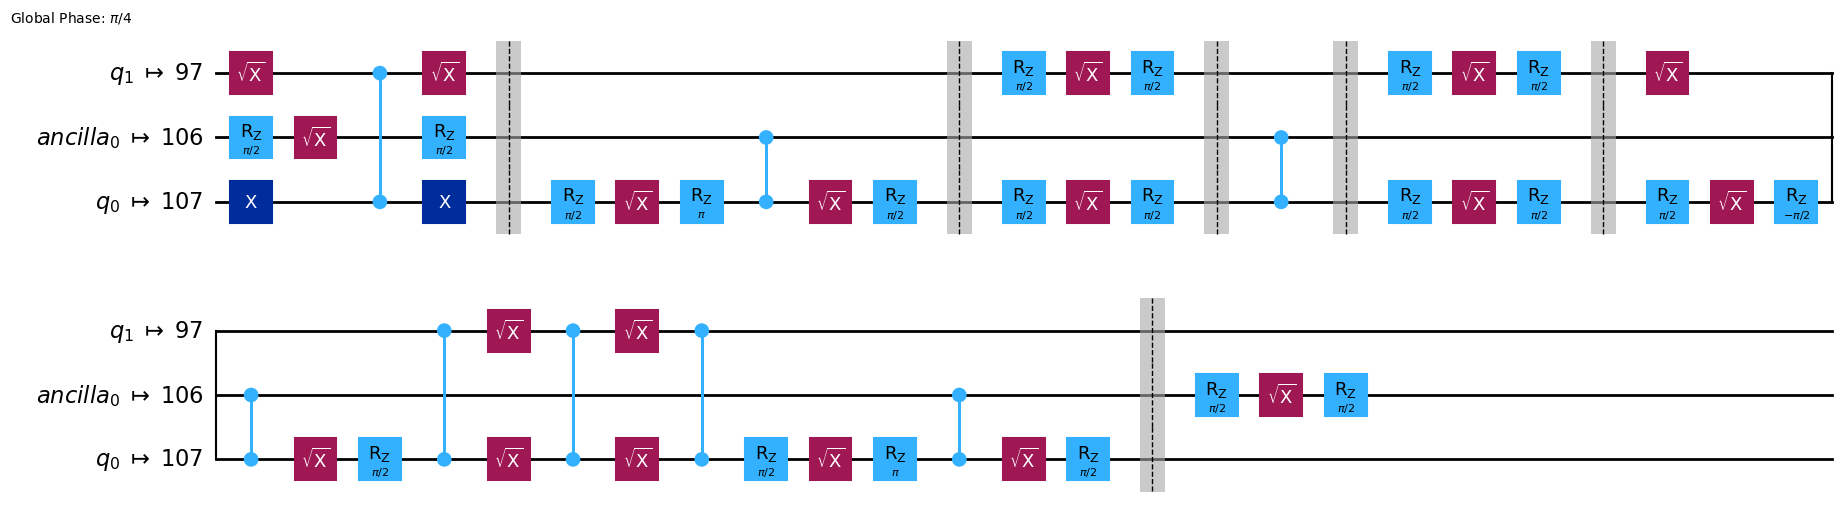

In [53]:
L = len(LCU.paulis)
n = nqubits
l = LCU.paulis[1]
lp = LCU.paulis[2] # from 1 to
j = 0 # from -1 to nqubits
part = "Re"

qc = local_hadamard_test(params1, nqubits=2, l=l, j=j, lp=lp, part=part)

qc_transpiled = transpile(qc, backend = backend, layout_method="dense",optimization_level=3)
# display(new_dense.draw("mpl", idle_wires= False))
display(qc_transpiled.draw("mpl", idle_wires=False))

#### Removing barriers

We want to remove the barriers (gray dashed lines) from the circuit, which prevents full circuit optimization during transpilation, using `RemoveBarriers`. 

Here is a demostration. 

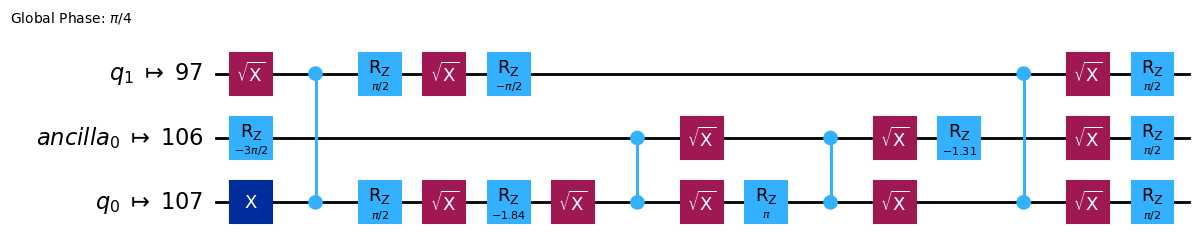

In [46]:
qc_nb = RemoveBarriers()(qc)
qc_transpiled_nb = transpile(qc_nb, backend, layout_method="dense", optimization_level=3)
display(qc_transpiled_nb.draw("mpl", idle_wires=False))

#### Transpiling the observables

We need to apply the layout of the transpiled circuit to the observables as well. The observables should be mapped to the corresponding physical qubits.

In [13]:
transpiled_obs = observable.apply_layout(qc_transpiled_nb.layout)

#### Building the Estimator

We import properties of the selected backend for Aer Simulation.

In [ ]:
from qiskit_aer.primitives import EstimatorV2 as AerEstimatorV2

# We import properties of the selected backend for Aer Simulation. 
estimator = AerEstimatorV2().from_backend(backend)
estimator.options.resilience_level = 2


In [15]:
job = estimator.run([(qc_transpiled_nb, transpiled_obs)])
result = job.result()

In [16]:
print(result)

PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>)), metadata={'target_precision': 0.0, 'circuit_metadata': {}, 'simulator_metadata': {'omp_enabled': True, 'parallel_experiments': 1, 'max_memory_mb': 40133, 'max_gpu_memory_mb': 0, 'time_taken_execute': 0.0835631, 'time_taken_parameter_binding': 6.66e-05}})], metadata={'version': 2})


#### Extracting the result

In [17]:
exp_value_list = result[0].data.evs
print(exp_value_list)

0.00018047125267706132


### Putting everything together

The `eval_circ()` function transpiles and evaluates a circuit using Aer EstimatorV2. It returns the expectation value of Pauli-Z on the ancilla qubit.

In [54]:

def eval_circ(circ, backend):
    """This circuit evaluates the Hadamard test for a given parameter using Aer EstimatorV2.
    
    The circuit has a single ancilla qubit as the LSB.
    The circuit is transpiled and optimized for the backend.
    We evaluate the expectation value of Pauli-Z on the ancilla qubit.
    
    Estimator Options:
    resilience level = 2
    layout_method = "dense"
    
    Args:
        circ: QuantumCircuit
            The Hadamard test circuit
        backend: Backend
        
    Returns:
        The expectation value of Pauli-Z on the ancilla qubit.
    """
    
    nqubits = circ.num_qubits - 1
    # Remove barriers
    circ = RemoveBarriers()(circ)
    
    # Construct the observables
    obs = SparsePauliOp("I"* nqubits + "Z")
    
    # Transpile the circuit and observables
    circ_transpiled = transpile(circ, backend=backend, layout_method="dense", optimization_level=3)
    transpiled_obs = obs.apply_layout(circ_transpiled.layout)
    
    # Define the estimator
    estimator = AerEstimatorV2().from_backend(backend)
    estimator.options.resilience_level = 2
    
    result = estimator.run([(circ_transpiled, transpiled_obs)]).result()
    exp_value = result[0].data.evs
    return exp_value.item()
    

In [41]:
result_eval_circ = eval_circ(qc, backend=backend)
print(type(result_eval_circ))
print(result_eval_circ)

<class 'float'>
0.00032737914165148485


In [40]:
result_eval_circ2 = eval_circ(local_hadamard_test(params1, nqubits=2, l=l, j=j, lp=lp, part="IM", lcu=LCU), backend=backend)
print(type(result_eval_circ2))
print(result_eval_circ2)

<class 'float'>
-0.0012671671176523005


The `eval_hadamard()` function combines every quantum step. It evaluates the local cost, given a set of parameters, $\alpha$.

In [65]:
def local_cost(param, lcu, Im_part=False): 
    """This function evaluates the Hadamard test for a given parameter and LCU.

    Args:
        param: float
            The parameter for the Hadamard test
        lcu: PauliList or SparsePauliOp object
            The Pauli decomposition of the matrix A. 

    Returns:
        exp_value_list: list
    """
    L = len(lcu.paulis)
    nqubits = lcu.num_qubits
    
    # Evaluate the denominator
    Denominator = 0
    # For the real part
    for l in range(L):
        for lp in range(L):
            circ = local_hadamard_test(param, l, -1, lp, part = "Re", lcu=lcu)
            # Multiplying coefficients with the expectation value.
            Denominator += abs(lcu.coeffs[l] * np.conjugate(lcu.coeffs[lp]) * eval_circ(circ, backend=backend))
    # Imaginary part
    if Im_part:
        for l in range(L):
            for lp in range(L):
                circ = local_hadamard_test(param, l, -1, lp, part = "Im", lcu=lcu)
                Denominator += abs(lcu.coeffs[l] * np.conjugate(lcu.coeffs[lp]) * eval_circ(circ, backend=backend)) * 1.0j
    
    # Evaluate the Numerator
    Numerator = 0
    for l in range(L):
        for lp in range(L):
            for j in range(nqubits): # j is from 0 to nqubits-1
                circ = local_hadamard_test(param, l, j, lp, nqubits=nqubits, part = "Re", lcu=lcu)
                Numerator += abs(lcu.coeffs[l] * np.conjugate(lcu.coeffs[lp]) * eval_circ(circ, backend=backend))
    # Imaginary part
    if Im_part:
        for l in range(L):
            for lp in range(L):
                for j in range(nqubits):
                    circ = local_hadamard_test(param, l, j, lp, nqubits=nqubits, part = "Im", lcu=lcu)
                    Numerator += abs(lcu.coeffs[l] * np.conjugate(lcu.coeffs[lp]) * eval_circ(circ, backend=backend)) * 1.0j
    
    # The final result
    local_cost = 1/2 + ( 1/(2*nqubits) * (Numerator / Denominator))
    return abs(local_cost)

Testing the function, `eval_hadamard` with respect to parameters [[pi/1, pi/2], [pi/1, pi/2]].

In [ ]:
params1 = [[pi/1, pi/2], [pi/1, pi/2]]

# Testing with only real part.
result_local_cost = local_cost(params1, LCU, Im_part=False)
print(type(result_local_cost))
print(result_local_cost)

<class 'numpy.complex128'>
(0.30172346452748977+0j)


In [ ]:
# Testing with combined imaginary part.
result_local_cost2 = local_cost(params1, LCU, Im_part=True)
print(type(result_local_cost2))
print(result_local_cost2)

<class 'numpy.complex128'>
(0.3017345708895015-0.00012960831150646062j)


In [45]:
result_local_cost3 = local_cost(params1, LCU, Im_part=False)
print(type(result_local_cost3))
print(result_local_cost3)

<class 'numpy.float64'>
0.7493433128679315


### Iterating over parameters

Since scipy's `minimize` function takes flat (1D) numpy arrays as inputs, we need to modify our `local_cost()` function by defining a `local_cost_flat()`.

In [ ]:
from scipy.optimize import minimize

nqubits = 2
num_layers = 2

# We need to reshape our parameters. In our case, reshape into (num_layers, nqubits) arrays. 
def local_cost_flat(parameters, lcu):
    parameters = np.reshape(parameters, (num_layers, nqubits))
    return local_cost(parameters, lcu, Im_part=False)

In [ ]:
# Testing the circuit with flat parameter inputs. 

params_flat = np.array([pi/1, pi/2, pi/1, pi/2])

result_local_cost_flat = local_cost(params1, LCU, Im_part=False)
print(type(result_local_cost_flat))
print(result_local_cost_flat)

In [ ]:

minimize(local_cost, x0=params1, args=(LCU, False), method="COBYLA")

## 4. Acknowledgements

This implementation is based on the work presented in the research paper [5] by Carlos Bravo-Prieto, Ryan LaRose, M. Cerezo, Yiğit Subaşı, Lukasz Cincio, and Patrick J. Coles.